In [1]:
import torch
from torch import nn
from torch.nn.functional import pad
from torchvision import models
# from transformers import XLMRobertaModel, RobertaModel, RobertaTokenizer
from transformers import AutoTokenizer, AutoModel

# from typing import List

In [ ]:
import pandas as pd

data = pd.read_csv('dev_sent_emo.csv')
data.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


In [4]:
speaker2id = { sp:i for i, sp in enumerate(data['Speaker'].unique()) }

data['Speaker_ID'] = data['Speaker'].apply(lambda x: speaker2id[x])

data.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Speaker_ID
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049",0
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",1
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",2
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",3
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505",4


In [ ]:
class M2FNetTextEmbedder(nn.Module):
    def __init__(self, device):
        super(M2FNetTextEmbedder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')
        self.encoder = AutoModel.from_pretrained('tae898/emoberta-base')
        self.model_max_tokens = self.tokenizer.model_max_length
        self.device = device

    def forward(self, diag_id):
        return self.encode(diag_id)

    def encode(self, diag_id):
        diag_uttrs = data[data['Dialogue_ID'] == diag_id]

        max_tokens = self.model_max_tokens - 2
        samples_ids = []
        attn_masks = []

        for i, row in diag_uttrs.iterrows():
            sequence = []
            target_uttr = self.tokenizer(self.tokenizer.eos_token*2 + \
                             f"{row['Speaker'].upper()}:{row['Utterance']}" + \
                                self.tokenizer.eos_token*2, add_special_tokens=False)
            sequence.append(target_uttr.input_ids)
            seq_len = len(target_uttr.input_ids)
            shift = 1
            while seq_len <= max_tokens:
                prev_idx = row['Utterance_ID'] - shift
                next_idx = row['Utterance_ID'] + shift
                if prev_idx in diag_uttrs['Utterance_ID'].values:
                    uttr_row = diag_uttrs[diag_uttrs['Utterance_ID'] == prev_idx].iloc[0]
                    uttr_str = f"{uttr_row['Speaker'].upper()}:{uttr_row['Utterance']} "
                    uttr_tokens = self.tokenizer(uttr_str, add_special_tokens=False).input_ids

                    sequence.insert(0, uttr_tokens)
                if next_idx in diag_uttrs['Utterance_ID'].values:
                    uttr_row = diag_uttrs[diag_uttrs['Utterance_ID'] == next_idx].iloc[0]
                    uttr_str = f"{uttr_row['Speaker'].upper()}:{uttr_row['Utterance']} "
                    uttr_tokens = self.tokenizer(uttr_str, add_special_tokens=False).input_ids

                    sequence.append(uttr_tokens)
                if prev_idx < 0 and next_idx >= diag_uttrs['Utterance_ID'].max():
                    break
                shift += 1
                seq_len = sum([len(ut) for ut in sequence])
            cls_tok = self.tokenizer(self.tokenizer.cls_token, add_special_tokens=False).input_ids
            eos_tok = self.tokenizer(self.tokenizer.eos_token, add_special_tokens=False).input_ids
            if seq_len > max_tokens:
                sequence = sequence[1:-1]
            sequence = [cls_tok] + sequence + [eos_tok]
            seq_flatten = torch.tensor([tok for uttr in sequence for tok in uttr], dtype=torch.long)
            input_ids = pad(seq_flatten, (0, 512-len(seq_flatten)), value=1).unsqueeze(0)
            attention_mask = torch.ones(512)
            attention_mask[(512-len(seq_flatten)):] = 0
            samples_ids.append(input_ids)
            attn_masks.append(attention_mask.unsqueeze(0))
        samples_ids_tensor = torch.stack(samples_ids).squeeze(1).to(device)
        attn_masks_tensor = torch.stack(attn_masks).squeeze(1).to(device)
        embs = self.encoder(input_ids=samples_ids_tensor, attention_mask=attn_masks_tensor).last_hidden_state[:, 0, :]
        return embs

In [6]:
import numpy as np

class SpeakerEmb1TextEmbedder(nn.Module): # Revisiting Multimodal Emotion Recognition in Conversation from the Perspective of Graph Spectrum

    def __init__(self, n_speakers, speaker_lambda, device):
        super(SpeakerEmb1TextEmbedder, self).__init__()
        self.m2fnet_embedder = M2FNetTextEmbedder(device=device)
        self.speaker_emb = nn.Embedding(n_speakers, 768)
        self.gru = nn.GRU(768, 768 // 2, bidirectional=True, num_layers=1)
        self.speaker_lambda = speaker_lambda
        self.device = device

    def forward(self, diag_id):
        return self.encode(diag_id)

    def encode(self, diag_id):
        diag_frame = data[data['Dialogue_ID'] == diag_id]
        diag_embs = self.m2fnet_embedder.encode(diag_id) # (uttr_count, hid_dim)
        diag_features, _ = self.gru(diag_embs)
        speakers = torch.tensor(np.array(diag_frame['Speaker_ID'], dtype=np.int32), dtype=torch.long).to(self.device)
        speaker_embs = self.speaker_emb(speakers) # (uttr_count, hid_dim)
        text_features = diag_features + speaker_embs

        return text_features

In [ ]:
# class SpeakerEmb2TextEmbedder:
#     def __init__(self, n_speakers, speaker_lambda):
#         self.tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base') # FacebookAI/roberta-base
#         self.roberta = AutoModel.from_pretrained('tae898/emoberta-base') # FacebookAI/roberta-base
#         self.gru = nn.GRU(768, 768 // 2, bidirectional=True, num_layers=1)
#         self.norm = nn.LayerNorm([4, 768])

#     def encode(self, diag_id):
#         diag_uttrs = data[data['Dialogue_ID'] == diag_id]
#         samples_ids = []
#         attn_masks = []
#         for i, row in diag_uttrs.iterrows():
#             cls_tok = self.tokenizer(self.tokenizer.cls_token, add_special_tokens=False).input_ids
#             eos_tok = self.tokenizer(self.tokenizer.eos_token, add_special_tokens=False).input_ids
#             target_uttr = self.tokenizer(row['Utterance'], add_special_tokens=False)

#             sequence = [cls_tok] + target_uttr.input_ids + [eos_tok]
#             seq_flatten = torch.tensor([tok for uttr in sequence for tok in uttr], dtype=torch.long)
#             input_ids = pad(seq_flatten, (0, 512-len(seq_flatten)), value=1)
#             attention_mask = torch.ones(512)
#             attention_mask[(512-len(seq_flatten)):] = 0
#             samples_ids.append(input_ids)
#             attn_masks.append(attention_mask)
#         samples_ids_tensor = torch.stack(samples_ids)
#         attn_masks_tensor = torch.stack(attn_masks)
#         hiddens = self.encoder(input_ids=samples_ids_tensor, attention_mask=attn_masks_tensor, output_hidden_states=True).hidden_states[-4:]
#         hiddens_tensor = torch.stack(hiddens)[:, :, 0, :].squeeze(2).permute(1, 0, 2) # (uttr_count, 4, 768)
#         uttr_emb = self.norm(hiddens_tensor).mean(dim=1) # (uttr_count, 768)

#         #AdaIGN - https://ojs.aaai.org/index.php/AAAI/article/view/29876
#         #COSMIC - https://arxiv.org/pdf/2010.02795

# Get Embeddings and Predicts

In [7]:
all_diags = data['Dialogue_ID'].unique()
train_size = int(0.8*len(all_diags))

train_diags = all_diags[:train_size]
test_diags = all_diags[train_size:]
len(train_diags), len(test_diags)

(91, 23)

In [8]:
label2id = { em: i for i, em in enumerate(data['Emotion'].unique()) }
id2label = { i: em for em, i in label2id.items() }
label2id

{'sadness': 0,
 'surprise': 1,
 'neutral': 2,
 'joy': 3,
 'anger': 4,
 'disgust': 5,
 'fear': 6}

In [9]:
data['Emotion_ID'] = data['Emotion'].map(label2id)


In [10]:
class EmbeddingClassifier(nn.Module):
    def __init__(self, embedder, embedder_kwargs, device='cpu'):
        super(EmbeddingClassifier, self).__init__()
        self.embedder = embedder(**embedder_kwargs, device=device)
        self.clf = nn.Linear(768, 7)
        self.device = device
    def forward(self, diag_id):
        embs = self.embedder(diag_id) # (uttr_count, 768)
        logits = self.clf(embs) # (uttr_count, 7)
        return logits, embs

In [ ]:
embeddings = None
logits = None

device = 'cuda'
embedder_kwargs = {
    'n_speakers': len(speaker2id),
    'speaker_lambda': 0.2,
}
# classifier = EmbeddingClassifier(embedder=M2FNetTextEmbedder, embedder_kwargs={}, device=device) # F1 = 0.252
# for param in classifier.embedder.parameters():
#     param.requires_grad = False

classifier = EmbeddingClassifier(embedder=SpeakerEmb1TextEmbedder, embedder_kwargs=embedder_kwargs, device=device) # 0.324
for param in classifier.embedder.m2fnet_embedder.parameters():
    param.requires_grad = False

classifier.to(device);

Some weights of RobertaModel were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from torch.optim import Adam
from sklearn.metrics import f1_score

num_epochs = 3
log_interval = 10

optimizer = Adam(classifier.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [26]:
step = 0

for epoch in range(num_epochs):
    train_loss = 0.
    for diag_id in train_diags:
        labels = torch.tensor(data.loc[data['Dialogue_ID'] == diag_id, 'Emotion_ID'].tolist(), dtype=torch.long, device=device)

        optimizer.zero_grad()

        outputs, _ = classifier(diag_id)

        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        step += 1
        if step % log_interval == 0:
            val_loss = 0.
            y_true = []
            y_pred = []
            for val_diag_id in test_diags:
                labels = torch.tensor(data.loc[data['Dialogue_ID'] == val_diag_id, 'Emotion_ID'].tolist(), dtype=torch.long, device=device)
                with torch.no_grad():
                    outputs, _ = classifier(val_diag_id)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                y_true.extend(labels.detach().cpu().reshape(-1).tolist())
                y_pred.extend(outputs.argmax(dim=1).detach().cpu().reshape(-1).tolist())

            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0.)
            print(f"Epoch {epoch}, step {step}: train_loss={train_loss / step:.3f}, val_loss={val_loss / len(test_diags):.3f}, F1={f1:.3f}")


Epoch 0, step 10: train_loss=1.906, val_loss=2.082, F1=0.157
Epoch 0, step 20: train_loss=2.055, val_loss=1.991, F1=0.183
Epoch 0, step 30: train_loss=1.999, val_loss=1.755, F1=0.300
Epoch 0, step 40: train_loss=2.011, val_loss=1.818, F1=0.285
Epoch 0, step 50: train_loss=1.909, val_loss=1.772, F1=0.286
Epoch 0, step 60: train_loss=1.866, val_loss=1.628, F1=0.308
Epoch 0, step 70: train_loss=1.814, val_loss=1.721, F1=0.263
Epoch 0, step 80: train_loss=1.788, val_loss=1.651, F1=0.301
Epoch 0, step 90: train_loss=1.757, val_loss=1.664, F1=0.271
Epoch 1, step 100: train_loss=0.137, val_loss=1.772, F1=0.232
Epoch 1, step 110: train_loss=0.268, val_loss=1.668, F1=0.278
Epoch 1, step 120: train_loss=0.380, val_loss=1.697, F1=0.296
Epoch 1, step 130: train_loss=0.469, val_loss=1.644, F1=0.271
Epoch 1, step 140: train_loss=0.529, val_loss=1.670, F1=0.248
Epoch 1, step 150: train_loss=0.578, val_loss=1.621, F1=0.304
Epoch 1, step 160: train_loss=0.622, val_loss=1.686, F1=0.307
Epoch 1, step 170

In [ ]:
for diag_id in test_diags:
    lgts, embs = classifier(diag_id)
    lgts, embs = lgts.cpu(), embs.cpu()
    if embeddings is None:
        embeddings = embs
    else:
        embeddings = torch.cat([embeddings, embs], dim=0)
        
    if logits is None:
        logits = lgts
    else:
        logits = torch.cat([logits, lgts], dim=0)

In [19]:
data.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Speaker_ID,Emotion_ID
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049",0,0
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",1,1
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",2,2
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",3,3
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505",4,0


In [28]:
test_mask = data['Dialogue_ID'].apply(lambda x: x in test_diags)
test_data = data[test_mask]
test_data.shape

(196, 13)

<Axes: >

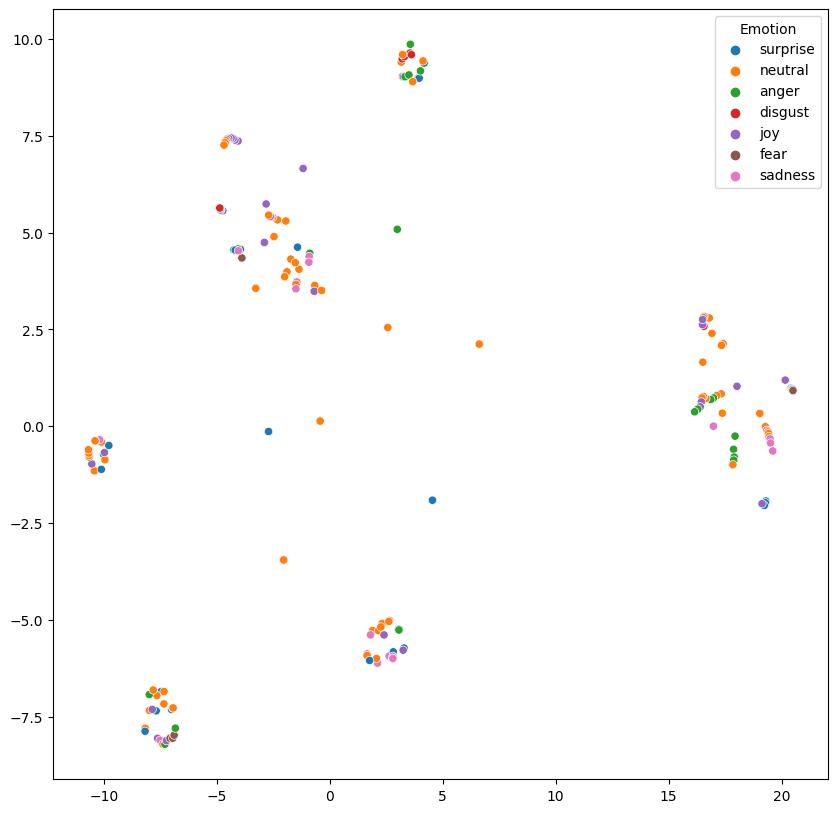

In [30]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

embs_numpy = embeddings.detach().numpy()

X_embedded = TSNE(n_components=2, random_state=42).fit_transform(embs_numpy)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=test_data['Emotion'])